<a href="https://colab.research.google.com/github/UFO-101/interpretability-hackathon/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA RTX A4000 (UUID: GPU-7717749d-7eb0-4ce7-704e-2c6e57f54d5a)
GPU 1: NVIDIA RTX A4000 (UUID: GPU-9413fe21-1167-c68e-f63b-71efd4da0dd2)
GPU 2: NVIDIA RTX A4000 (UUID: GPU-ee364761-a1a1-90d4-d422-6670335c0846)
GPU 3: NVIDIA RTX A4000 (UUID: GPU-764b05fb-a8ca-cc5f-68a3-a28526803f66)
GPU 4: NVIDIA RTX A4000 (UUID: GPU-7dd2f9fe-a16d-08b3-48de-d93ef560e886)
GPU 5: NVIDIA RTX A4000 (UUID: GPU-e795136e-b448-ed30-009e-7e16cd245cf7)
GPU 6: NVIDIA RTX A4000 (UUID: GPU-c8a8662f-2697-fd00-09ff-f0e01a75e65b)
GPU 7: NVIDIA RTX A4000 (UUID: GPU-865c3d64-c6eb-f368-c392-047fd2bd90e2)


In [2]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the EasyTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB:
    import os
    os.system("pip install git+https://github.com/neelnanda-io/Easy-Transformer.git")
    os.system("pip install git+https://github.com/UFO-101/PySvelte.git") 
    os.system("pip install infect")

Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_23549/73746255.py:14: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_23549/73746255.py:15: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


In [3]:
import torch
from easy_transformer import EasyTransformer, EasyTransformerConfig
import tqdm
import torch.nn.functional as F
import inflect
inflect_engine = inflect.engine()
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moving model to device:  cuda
Moving model to device:  cuda
before training

Accuracy: 1.5 %
Loss 5.024593353271484


  0%|          | 0/3001 [00:00<?, ?it/s]


Accuracy: 0.0 %
Loss 5.208566665649414


 17%|█▋        | 516/3001 [00:05<00:24, 101.39it/s]


Accuracy: 89.0625 %
Loss 0.7185026407241821


 34%|███▍      | 1027/3001 [00:09<00:13, 150.05it/s]


Accuracy: 93.75 %
Loss 0.2501816153526306


 50%|█████     | 1514/3001 [00:14<00:13, 111.56it/s]


Accuracy: 96.875 %
Loss 0.10434803366661072


 67%|██████▋   | 2012/3001 [00:19<00:10, 98.90it/s] 


Accuracy: 100.0 %
Loss 0.02404848113656044


 84%|████████▍ | 2530/3001 [00:22<00:03, 156.46it/s]


Accuracy: 100.0 %
Loss 0.02446240745484829


100%|██████████| 3001/3001 [00:26<00:00, 112.72it/s]



Accuracy: 98.4375 %
Loss 0.02949213795363903


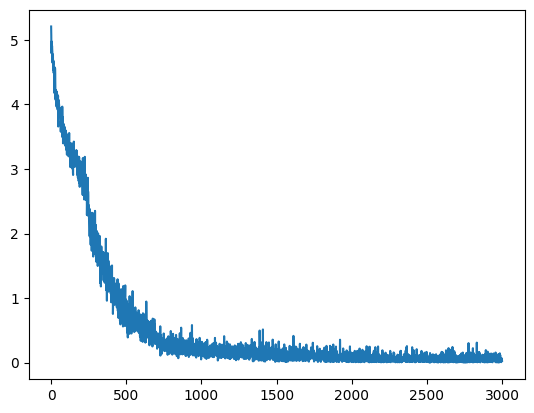

In [4]:
vocab_size = 100
sequence_length = 10
batch_size = 64

tiny_cfg = EasyTransformerConfig(
    d_model=16,
    d_head=8,
    n_heads=2,
    d_mlp=32,
    n_layers=1,
    n_ctx=50,
    act_fn="solu_ln",
    d_vocab=vocab_size,
    normalization_type="LN",
    use_attn_result=True,
    seed=23,
)
tiny_model = EasyTransformer(tiny_cfg).to(device)
tiny_optimizer = torch.optim.Adam(tiny_model.parameters(), lr=1e-3)
cross_entropy_loss = torch.nn.CrossEntropyLoss()


def evaluate_model(test_model, batch_size, print_output, number_to_print=0):
    test_batch = torch.randint(0, vocab_size, (batch_size, sequence_length)).to(device)
    output_logits = test_model(test_batch, return_type="logits")

    smallest_elements = torch.min(test_batch, dim=1, keepdim=False)[0]
    one_hots = torch.nn.functional.one_hot(smallest_elements, num_classes=tiny_cfg.d_vocab).to(torch.float32)
    loss = cross_entropy_loss(output_logits[:, -1], one_hots)

    if print_output:
        output_probs = torch.softmax(output_logits, dim=-1) # Convert logits to probabilities
        output_tokens = torch.argmax(output_probs, dim=-1) # Get the most likely tokens
        output_tokens = output_tokens[:, -1] # Only take the last token of each sequence
        test_batch_lists = test_batch.cpu().tolist()
        outputs_list = output_tokens.cpu().tolist()
        correct_count = 0
        for index, (sequence, answer_given) in enumerate(list(zip(test_batch_lists, outputs_list))):
            correct_answer = min(sequence)
            answer_in_list = answer_given in sequence
            if answer_given == correct_answer:
                correct_count += 1
            if index < number_to_print:
                print("sequence: ", sequence, "answer_given: ", answer_given)
                if answer_given == correct_answer:
                    print("Correct! Answer is: ", correct_answer)
                elif answer_in_list:
                    answer_given_rank = sorted(list(set(sequence)), reverse=False).index(answer_given)
                    print("Incorrect! Answer given:", answer_given, "which is the", inflect_engine.ordinal(answer_given_rank + 1) , "smallest in the list (not including duplicate)")
                else:
                    print("Incorrect! Answer given:", answer_given, "which is not in the sequence")

        print("\nAccuracy:", correct_count / len(output_tokens) * 100, "%")
        print("Loss", loss.item())
        # print('output_logits[:, -1][0]', output_logits[:, -1][0])
        # print('one hots[0]', one_hots[0])

    return loss

loss_history = []
print('before training')
loss = evaluate_model(tiny_model, batch_size=3000, print_output=True)
for epoch in tqdm.tqdm(range(3001)):
    loss = evaluate_model(tiny_model, batch_size=batch_size, print_output=epoch % 500 == 0, number_to_print=0)
    loss.backward()
    loss_history.append(loss.item())
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()
plt.plot(loss_history)

In [16]:
from importlib import reload
import pysvelte
reload(pysvelte)

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def show_attention_pattern_for_random_input(publish=False):
    example_sequence = torch.randint(low=0, high=vocab_size, size=(sequence_length,)).to(device)
    pysvelte_component = pysvelte.AttentionMulti(input=example_sequence, easy_transformer=tiny_model)
    if publish:
        pysvelte_component.publish("/workspaces/interpretability/figure.html", source_map=True)
    pysvelte_component.show()


# for act_name in model_cache:
#     print(act_name)

for i in range(5):
    show_attention_pattern_for_random_input(publish = i == 0)

input tensor([66, 96, 64, 31, 62, 13, 58, 90, 18, 14], device='cuda:0') seq_len 10
attn_pattern.shape torch.Size([2, 10, 10])
induction_stripe.shape torch.Size([2, 6])
induction_scores.shape torch.Size([2])
induction_scores tensor([0.1823, 0.1873], device='cuda:0')


input tensor([58, 80, 21, 14, 78,  2, 31, 80, 13, 38], device='cuda:0') seq_len 10
attn_pattern.shape torch.Size([2, 10, 10])
induction_stripe.shape torch.Size([2, 6])
induction_scores.shape torch.Size([2])
induction_scores tensor([0.1822, 0.1892], device='cuda:0')


input tensor([84, 47, 15, 22, 91, 87, 69, 56, 82, 97], device='cuda:0') seq_len 10
attn_pattern.shape torch.Size([2, 10, 10])
induction_stripe.shape torch.Size([2, 6])
induction_scores.shape torch.Size([2])
induction_scores tensor([0.1536, 0.1594], device='cuda:0')


input tensor([ 2, 61,  4, 54, 13, 88, 69, 42, 85, 87], device='cuda:0') seq_len 10
attn_pattern.shape torch.Size([2, 10, 10])
induction_stripe.shape torch.Size([2, 6])
induction_scores.shape torch.Size([2])
induction_scores tensor([0.2501, 0.2222], device='cuda:0')


input tensor([83, 57, 61,  9, 18,  0, 73, 53, 43,  7], device='cuda:0') seq_len 10
attn_pattern.shape torch.Size([2, 10, 10])
induction_stripe.shape torch.Size([2, 6])
induction_scores.shape torch.Size([2])
induction_scores tensor([0.1707, 0.1671], device='cuda:0')


In [6]:
for act_name in model_cache:
    print(act_name)

NameError: name 'model_cache' is not defined

q_weights torch.Size([2, 16, 8])


TypeError: inner() got multiple values for argument 'ax'

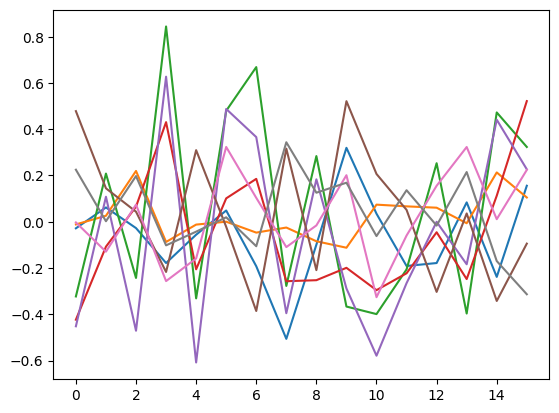

In [ ]:
# print weights for key and query
# print('tiny_model.blocks', tiny_model.blocks)
q_weights = tiny_model.blocks[0].attn.W_Q
print('q_weights', q_weights.shape)
# print(tiny_model.blocks[0].attn.W_Q.shape)
plt.plot(q_weights[0].detach().cpu().numpy())
axs = plt.imshow(q_weights[0].detach().cpu().numpy(), ax = plt)